#Predictive Analysis

## Imports

In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer


In [ ]:
from pandas.core.reshape.merge import merge
xtrain = read_csv("Xtrain_hgcGIrA.csv")
ytrain = read_csv("Ytrain_yL5OjS4.csv")
xtest = read_csv("Xtest.csv")
ytrain = ytrain.loc[:, ~ytrain.columns.str.contains('^Unnamed')]

## Features

In [ ]:
def addDate(x):
  Xtrain_date = x.copy()

  # convert Time to Datetime
  Xtrain_date['date'] = pd.to_datetime(Xtrain_date['date'], format='%Y/%m/%d')

  # Add new column for weekday
  day = Xtrain_date['date'].dt.day
  weekday = Xtrain_date['date'].dt.weekday
  month = Xtrain_date['date'].dt.month
  Xtrain_date.insert(1,'day',day)
  Xtrain_date.insert(1,'weekday',weekday)
  Xtrain_date.insert(2,'month',month)

  return Xtrain_date

In [ ]:
def addTime(x):
  Xtrain_time = x.copy()
  # convert Time to Datetime

  # Add new column for weekday
  hour = pd.to_datetime(Xtrain_time['hour'], format='%H:%M:%S').dt.hour
  Xtrain_time.insert(1,'intHour',hour)
  return Xtrain_time

In [ ]:
def addRoute(x):
  Xtrain_route = x.copy()
  Route = 1
  last = this = Xtrain_route.query("train == 1")["station"].unique()
  x = []
  x.append(1)
  for tra in range(2,56):
    this = Xtrain_route.query("train ==" + str(tra))["station"].unique()
    if last.all() != this.all():
      Route += 1
    x.append(Route)
    last = this

  y = []
  for j in Xtrain_route["train"].unique():
    l = int(j) - 1
    for k in range(0,Xtrain_route.query("train ==" + str(j)).count().max()):
      y.append(x[l])
  Xtrain_route.insert(7,'route',y)
  return Xtrain_route


In [ ]:
def stationDummy(x):
  Xtrain_station = x.copy()

  for i in Xtrain_station["station"].unique():
    Xtrain_station[str(i)] = Xtrain_station["station"] == i
    Xtrain_station[str(i)] = Xtrain_station[str(i)].astype(int)
  return Xtrain_station

In [ ]:
def dropCat(t):
  Xtrain_dropCat = t.copy()
  holdt = pd.DataFrame()
  holdt["type"] = Xtrain_dropCat.dtypes
  #print(holdt)
  holdt["float"] = holdt["type"] == 'float64'
  holdt["int"] =  holdt["type"] == 'int64'
  return Xtrain_dropCat.drop([str(holdt.index[col]) for col in range(0,holdt.shape[0]) if holdt["int"][col] != True and holdt["float"][col] != True], axis=1)

In [ ]:
def routeDummy(x):
  X_dummy = x.copy()
  for i in range(X_dummy["route"].min(),X_dummy["route"].max() + 1):
    X_dummy["route" + str(i)] = X_dummy["route"] == i
    X_dummy["route" + str(i)] = X_dummy["route" + str(i)].astype(int)
  X_dummy = X_dummy.drop("route",axis = 1)
  return X_dummy

In [ ]:
def trainDummy(x):
    X_dummy = x.copy()
    for i in range(X_dummy["train"].min(),X_dummy["train"].max() + 1):
        X_dummy["train " + str(i)] = X_dummy["train"] == i
        X_dummy["train " + str(i)] = X_dummy["train " + str(i)].astype(int)
    X_dummy = X_dummy.drop("train",axis = 1)
    return X_dummy

In [ ]:
def allChanges(x):
  x_old = x.copy()
  return dropCat(trainDummy(routeDummy(stationDummy(addRoute(addTime(addDate(x_old)))))))

In [ ]:
datasetnull = allChanges(xtrain)

In [ ]:
datasetnull.head()

,intHour,weekday,month,day,way,composition,p1q0,p2q0,p3q0,p0q1,...,train 46,train 47,train 48,train 49,train 50,train 51,train 52,train 53,train 54,train 55
0,6.0,0,1,7,0,2,NaN,NaN,NaN,0.201,...,0,0,0,0,0,0,0,0,0,0
1,6.0,1,1,8,0,2,NaN,NaN,NaN,0.204,...,0,0,0,0,0,0,0,0,0,0
2,6.0,3,1,10,0,2,NaN,NaN,NaN,0.213,...,0,0,0,0,0,0,0,0,0,0
3,6.0,4,1,11,0,2,NaN,NaN,NaN,0.213,...,0,0,0,0,0,0,0,0,0,0
4,6.0,0,1,14,0,2,NaN,NaN,NaN,0.210,...,0,0,0,0,0,0,0,0,0,0


## Null Values

### KNN

In [ ]:
imputer = KNNImputer(n_neighbors=3)
dataset = imputer.fit_transform(datasetnull)

## Models

### Build Models

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(dataset, ytrain, test_size=0.20, random_state=1, shuffle=True)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(40)
LargeModel=keras.models.Sequential([
    
    keras.layers.Dense(1024, input_dim = X_train.shape[1]), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.01),

    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(), 
    keras.layers.Dropout(0.05),
    keras.layers.Dense(units=1, activation="linear"),
],name="Larger_network",)
LargeModel.summary()

Model: "Larger_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              114688    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                    

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.005, weight_decay=5e-4)

In [ ]:
LargeModel.compile(optimizer=optimizer, 
            loss='mean_squared_error')

In [ ]:
checkpoint_name = 'Weights\Checkpoint.hdf5' 
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
history = LargeModel.fit(X_train, Y_train,
                    epochs=500, batch_size=1024,
                    validation_data=(X_validation, Y_validation), 
                    callbacks=callbacks_list, 
                    verbose=1)

Epoch 1/500
25/25 [==============================] - ETA: 0s - loss: 1.8206
Epoch 1: val_loss improved from inf to 4.77379, saving model to Weights\Checkpoint.hdf5
25/25 [==============================] - 10s 263ms/step - loss: 1.8206 - val_loss: 4.7738
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 0.0976
Epoch 2: val_loss improved from 4.77379 to 0.61076, saving model to Weights\Checkpoint.hdf5
25/25 [==============================] - 6s 238ms/step - loss: 0.0976 - val_loss: 0.6108
Epoch 3/500
25/25 [==============================] - ETA: 0s - loss: 0.0494
Epoch 3: val_loss improved from 0.61076 to 0.09616, saving model to Weights\Checkpoint.hdf5
25/25 [==============================] - 6s 239ms/step - loss: 0.0494 - val_loss: 0.0962
Epoch 4/500
25/25 [==============================] - ETA: 0s - loss: 0.0355
Epoch 4: val_loss improved from 0.09616 to 0.04577, saving model to Weights\Checkpoint.hdf5
25/25 [==============================] - 6s 250ms/step - loss: 0

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [p0q0]')
  plt.rcParams['figure.figsize'] = (18, 9)
  plt.legend()
  plt.grid(True)

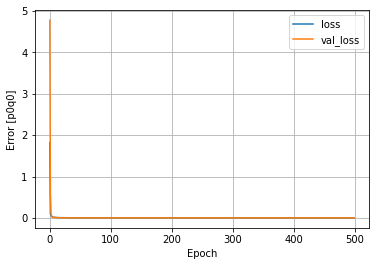

In [ ]:
plot_loss(history)

In [ ]:
LargeModel.load_weights("Weights\Checkpoint.hdf5")

In [ ]:
xtest_1 = pd.DataFrame(allChanges(xtest)).copy()
xtest_2 = pd.DataFrame(imputer.fit_transform(xtest_1))
xtest_2.columns = xtest_1.columns

Y_predict2 = LargeModel.predict(xtest_2)

430/430 [==============================] - 3s 7ms/step


In [ ]:
Ypr = pd.DataFrame(Y_predict2).copy()
Ypr.rename(columns = {0:'p0q0'}, inplace = True)
Ypr.index = np.arange(1, len(Ypr) + 1)
Ypr.to_csv("predictionDNN.csv")